# 0 - IMPORTS

In [1]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt

2024-04-10 22:51:01.301816: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 22:51:01.712284: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 22:51:03.077210: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 22:51:06.451204: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 1 Setup and Load Data

In [2]:
# Avoid OOM errors by setting GPU memory consumption growth
#cpus = tf.config.experimental.list_physical_devices('CPU')
#for cpu in cpus:
#    tf.config.experimental.set_memory_growth(cpu, True)

## 1.2 Remove dodgy images

In [3]:
import cv2
import imghdr

/tmp/ipykernel_19266/4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [4]:
data_dir = 'data'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [5]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

libpng warning: iCCP: known incorrect sRGB profile


## 1.3 Load Data

In [6]:
import numpy as np
from matplotlib import pyplot as plt

In [7]:
data = tf.keras.utils.image_dataset_from_directory('data')

data_iterator = data.as_numpy_iterator()

# Get another batch from the iterator
batch = data_iterator.next()

Found 177 files belonging to 2 classes.


2024-04-10 22:51:16.112269: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


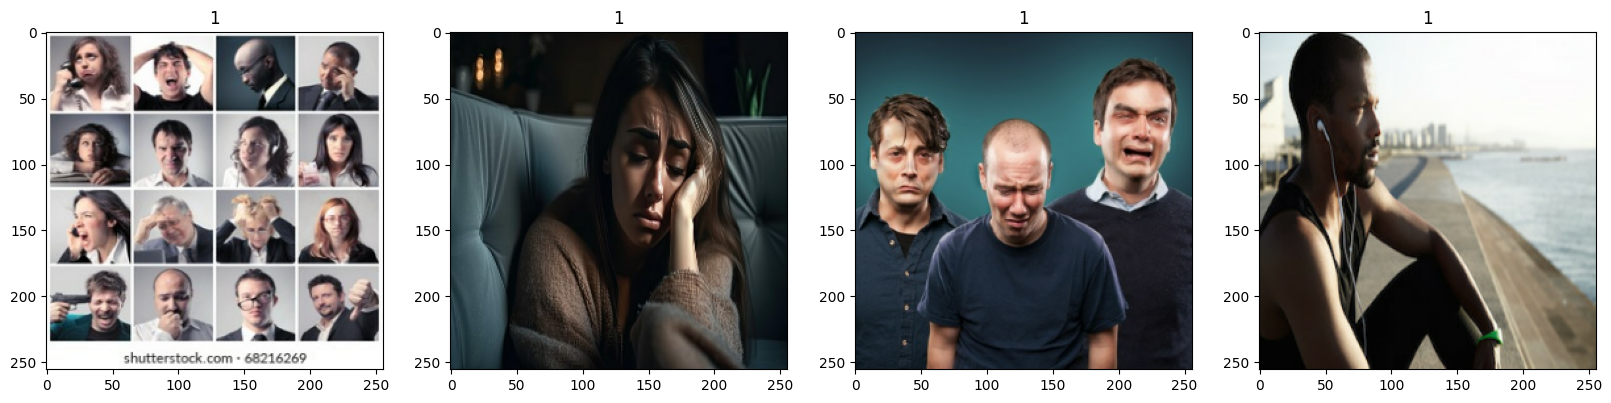

In [8]:
# Checking the classes
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    
# Class 0 - Happy
# Class 1 - Sad

# 2 Preprocess Data

## 2.1 Scale Data

In [9]:
# Scale data
data = data.map(lambda x, y: (x/255, y))
# Create iterator
scaled_iterator = data.as_numpy_iterator()
# Create batch
batch = scaled_iterator.next()

2024-04-10 22:51:17.684371: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


## 2.2 Split Data

In [10]:
len(data)

6

In [11]:
train_size = (len(data)*.7)
val_size = (len(data)*.2)
test_size = (len(data)*.1)+1

In [12]:
train = data.take(int(train_size))
val = data.skip(int(train_size)).take(int(val_size))
test = data.skip(int(train_size+val_size)).take(int(test_size))

# 3 Deep Model

## 3.1 Build Deep Learning Model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [14]:
model = Sequential()

In [15]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/home/vagner/.pyenv/versions/3.11.4/envs/venv_projetos2/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [16]:
model.compile('adam', loss= tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

## 3.2 Train

In [18]:
logdir = 'logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=6, validation_data=val, callbacks=[tensorboard_callback])
# epochs=6 due local machine lack of ram memory and process power

Epoch 1/6


2024-04-10 22:51:26.003019: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.5664 - loss: 1.0874

2024-04-10 22:51:33.421627: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5562 - loss: 1.1002 - val_accuracy: 0.5312 - val_loss: 0.8562
Epoch 2/6


2024-04-10 22:51:34.154093: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.5423 - loss: 0.7700

2024-04-10 22:51:45.300950: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 22:51:53.458435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 151 of 256
2024-04-10 22:51:54.396375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.5510 - loss: 0.7624 - val_accuracy: 0.5312 - val_loss: 0.6530
Epoch 3/6


2024-04-10 22:51:55.525000: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.5026 - loss: 0.6594

2024-04-10 22:52:00.228735: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5083 - loss: 0.6549 - val_accuracy: 0.5938 - val_loss: 0.5483
Epoch 4/6


2024-04-10 22:52:01.158685: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6875 - loss: 0.5655

2024-04-10 22:52:17.893122: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.6969 - loss: 0.5664 - val_accuracy: 0.5938 - val_loss: 0.7405
Epoch 5/6


2024-04-10 22:52:18.995732: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.6217 - loss: 0.7111

2024-04-10 22:52:22.472831: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6396 - loss: 0.6909 - val_accuracy: 0.9062 - val_loss: 0.4978
Epoch 6/6


2024-04-10 22:52:23.628725: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.8366 - loss: 0.4624

2024-04-10 22:52:26.666468: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 958ms/step - accuracy: 0.8333 - loss: 0.4583 - val_accuracy: 0.7812 - val_loss: 0.3708


## 3.3 Plot Performance

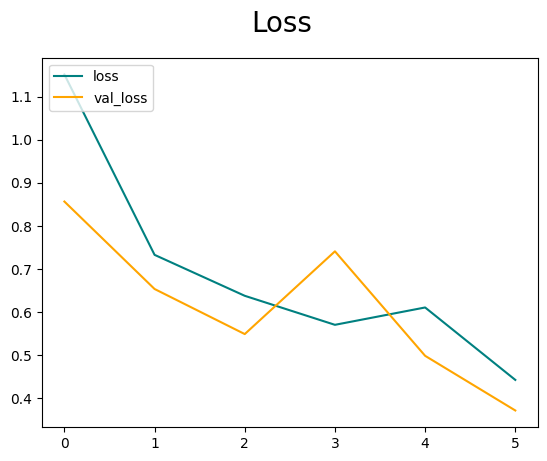

In [19]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

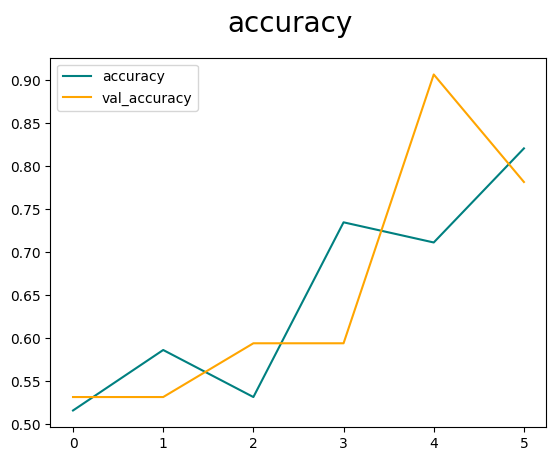

In [20]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

# 4 Evaluate Performance

## 4.1 Evaluate

In [21]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [22]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [23]:
len(test)

1

In [24]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

2024-04-10 22:52:31.464910: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


2024-04-10 22:52:32.197985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [25]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 1.0, Recall: 0.5, Accuracy: 0.7647058963775635


## 4.2 Test

Happy Test

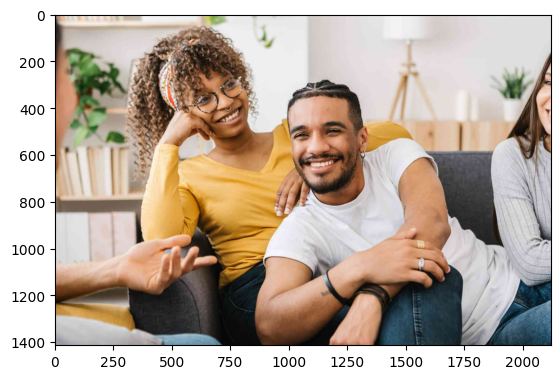

In [26]:
img = cv2.imread('happy_test.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

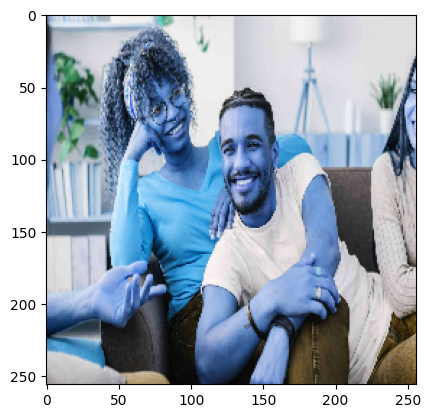

In [27]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [28]:
yhat = model.predict(np.expand_dims(resize/255, 0))

if yhat > 0.5:
    print('Predicted class is sad')
else:
    print('Predicted class is happy')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Predicted class is happy


Sad Test

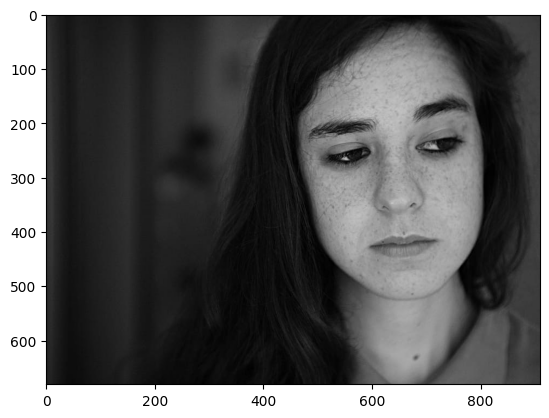

In [29]:
img = cv2.imread('sad_test.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

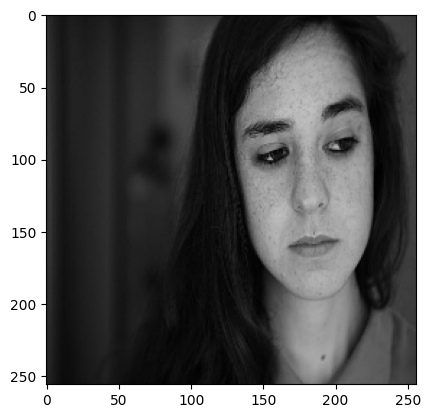

In [30]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [31]:
yhat = model.predict(np.expand_dims(resize/255, 0))

if yhat > 0.5:
    print('Predicted class is sad')
else:
    print('Predicted class is happy')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted class is sad


# 5 Save Model

## 5.1 Save Model

In [32]:
from tensorflow.keras.models import load_model

In [33]:
model.save(os.path.join('models', 'happy_sad_model.h5'))

new_model = load_model(os.path.join('models', 'happy_sad_model.h5'))

yhat_new = new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


In [34]:
if yhat_new > 0.5:
    print('Predicted class is sad')
else:
    print('Predicted class is happy')

Predicted class is sad
